In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel('data/Report_21_050718_3.xls')

In [4]:
df_demographics = pd.read_excel('data/Proteomics-Subjects_Wcodes.xlsx')

In [5]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df_demographics.columns = df_demographics.columns.str.replace(' ','_').str.lower()

In [6]:
'''
Converting long data to wide data
There are 12 subjects per group with 2 different dosages and total of 3 groups for 72 rows. 
We first identify the 72 columns, iterate through them and create one row per that item using pivot.
'''
out = pd.DataFrame()
for i in list(df.columns[((df.columns.str.endswith('_1') | df.columns.str.endswith('_2')))]):
    pat_info = i.split('_')
    df['pat_id'] = pat_info[0][1:]
    row = df.pivot(index='pat_id', columns='uniprot_id', values=i)
    row['dt_start'] = pat_info[1]
    row['dt_end'] = pat_info[2]
    row['dose']  = pat_info[3][:-2]
    row['group']  = pat_info[0][0]
    out = out.append(row)

In [7]:
out.index = out.index.astype('int64')
df_demographics.set_index('id',inplace=True)
out = out.join(df_demographics)

In [9]:
data = out

# Visualize gender impact on suicide

We see that gender does not have an impact here. As in, the data has equal number of males and females in both categories.

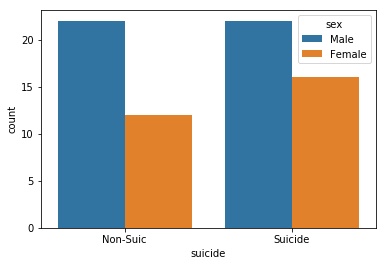

In [10]:
ax = sns.countplot(x="suicide", hue="sex", data=data)

In [11]:
data = data.drop(['group','gr','sex'], axis=1)

In [40]:
data.suicide.replace(to_replace=['Non-Suic', 'Suicide'], value=[0, 1], inplace=True)
data_y = data['suicide']
data_x = data.drop('suicide', axis = 1)

# Use random forest to identify important features

In [41]:
import warnings
from sklearn.ensemble import RandomForestClassifier

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    forest = RandomForestClassifier(n_estimators=50,class_weight="balanced")
    forest.fit(data_x,data_y)

In [42]:
importances = forest.feature_importances_

In [43]:
indices = np.argsort(importances)[::-1]

df_list = []

for f in range(data_x.shape[1]):
    df_list.append([list(data_x.columns)[indices[f]], importances[indices[f]]])
    
feature_rank = pd.DataFrame(df_list)
feature_rank = feature_rank.rename(columns={0:'feature',1:'importance'})

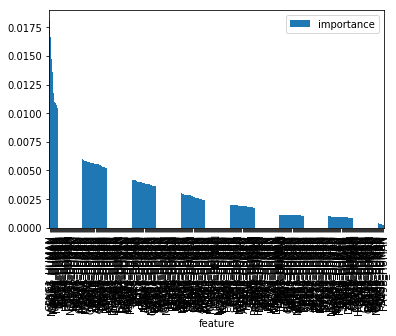

In [44]:
feature_rank[feature_rank['importance']>0].plot.bar(x='feature', y='importance', rot=90)

There are totally around 307 features that have non zero importance.

# Visualize the distribution of the most important feature identified by Random Forest

CPNE1_HUMAN


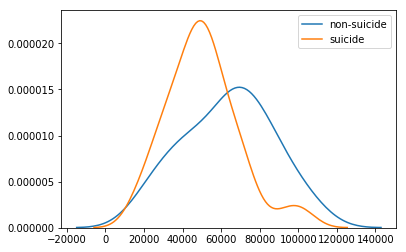

In [45]:
feature1 = feature_rank.iloc[0]['feature']
print(feature1)
sns.kdeplot(data[(data['suicide']==0)]['FGF9_HUMAN'],label='non-suicide')
sns.kdeplot(data[(data['suicide']==1)]['FGF9_HUMAN'],label='suicide')

# Run t-test to see which features are statistically significant between two groups

In [54]:
import scipy 

In [56]:
feature = 'FGF9_HUMAN'

In [57]:
scipy.stats.mannwhitneyu(data[data['suicide']==0][feature], data[data['suicide']==1][feature], use_continuity=True, alternative=None)[1]

0.004817040732475264

In [59]:
from scipy import stats

pvalues = []
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    feature = row['feature']
    if feature != 'dt_end':
        p = scipy.stats.mannwhitneyu(data[data['suicide']==0][feature], data[data['suicide']==1][feature], use_continuity=True, alternative=None)[1]
        
        pvalues.append([feature,p])

pvalues = pd.DataFrame(pvalues)
pvalues = pvalues.rename(columns={0:'feature',1:'pvalues'})
pvalues

,feature,pvalues
0,CPNE1_HUMAN,0.000380
1,SBDS_HUMAN,0.001373
2,MBOA7_HUMAN,0.000841
3,CN166_HUMAN,0.002048
4,MA2A1_HUMAN,0.000592
5,CMC1_HUMAN,0.323897
6,GEPH_HUMAN,0.021449
7,MBLC2_HUMAN,0.031762
8,GNAL_HUMAN,0.012215
9,HEM2_HUMAN,0.493250


In [63]:
pvalues[pvalues['pvalues']<0.05/1135]

,feature,pvalues


At a 0.05 significance level, there are 272 features that are statistically significant between the two groups.